# Data Transformation Diversity and Inclusivity

Dans cette partie nous allons formater la table que nous allons utiliser pour nos algorithmes.
Dans un premier temps nous choississons comme objectif de prédire les recettes d'un film.
On va donc prendre en compte toutes les données relatives au travail en amont de la sortie et donc sortir les donnnées issues des utilisateurs comme par exemple la popularité.
Dans un deuxième temps on va essayer de tester une hypothèse sur ces revenues :
Est-ce que la diversité (sexe, nationnalité) influence ces revenus ?

In [221]:
# Libraries import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

In [222]:
# Dataset import

credits = pd.read_csv('./archive/credits.csv', delimiter=',',index_col="id")
# keywords = pd.read_csv('./archive/keywords.csv', delimiter=',',index_col="id") # Pas très informatif pour notre question
movies = pd.read_csv('./archive/movies_metadata.csv', delimiter=',').\
                     drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                     drop([19730, 29503, 35587]) 

/tmp/ipykernel_1333918/172605203.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv('./archive/movies_metadata.csv', delimiter=',').\


In [223]:
movies['id'] = movies['id'].astype('int64') # incorrect datatype for merge 
df = movies.merge(credits, on='id')

In [224]:
# Converssion Json format en nominal format
def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

Pour obtenir cette notion de diversité, on peut ce baser sur le genre des personnes et leur ordre d'importance.
Le genre est associé au personnage et nom à l'acteur. (2 = homme, 1 = femme)
Pour l'équipe de tournage, on a accès au genre mais connaitre la position dans l'organigramme et donc son influence est plus compliqué.

Après avoir analyser les données il est apparu qu'il n'y avait pas de différence entre le genre du charactère et le genre de l'acteur

In [225]:
# for i in credits.crew:
#     print(i)
#     break

In [226]:
# df.keywords = df.keywords.map(lambda x: [d['name'] for d in get_dictionary(x)]).map(lambda x: ','.join(map(str, x)))
df.genres = df.genres.map(lambda x: [d['name'] for d in get_dictionary(x)]).map(lambda x: ','.join(map(str, x)))
# df.production_companies = df.production_companies.map(lambda x: [d['name'] for d in get_dictionary(x)]).map(lambda x: ','.join(map(str, x))) # trop de valeur manquantes
df.spoken_languages = df.spoken_languages.map(lambda x: [d['name'] for d in get_dictionary(x)]).map(lambda x: ','.join(map(str, x)))
# df.production_countries = df.production_countries.map(lambda x: [d['name'] for d in get_dictionary(x)]).map(lambda x: ','.join(map(str, x)))

# New columns
# df['characters'] = df.cast.map(lambda x: [d['character'] for d in get_dictionary(x)]).map(lambda x: ','.join(map(str, x)))
df['characters_gender'] = df.cast.map(lambda x: [d['gender'] for d in get_dictionary(x)]).map(lambda x: ','.join(map(str, x)))
# df['actors'] = df.cast.map(lambda x: [d['name'] for d in get_dictionary(x)]).map(lambda x: ','.join(map(str, x)))
# df['actors_order'] = df.cast.map(lambda x: [d['order'] for d in get_dictionary(x)]).map(lambda x: ','.join(map(str, x)))
# df.crew = df.crew.map(lambda x: [d['name'] for d in get_dictionary(x)]).map(lambda x: ','.join(map(str, x)))
df['crew_gender'] = df.crew.map(lambda x: [d['gender'] for d in get_dictionary(x)]).map(lambda x: ','.join(map(str, x)))


In [227]:
df.pop('production_companies')
df.pop('production_countries')
df.pop('cast')
df.pop('crew')
df.pop('original_title')
df.pop('popularity')
df.pop('tagline')
df.pop('vote_average')
df.pop('vote_count')
df.pop('overview')
df.pop('id')

0           862
1          8844
2         15602
3         31357
4         11862
          ...  
45533    439050
45534    111109
45535     67758
45536    227506
45537    461257
Name: id, Length: 45538, dtype: int64

In [228]:
df.head()

,adult,budget,genres,original_language,release_date,revenue,runtime,spoken_languages,characters_gender,crew_gender
0,False,30000000,"Animation,Comedy,Family",en,1995-10-30,373554033.0,81.0,English,"2,2,2,2,2,2,1,0,2,1,2,1,2","2,2,2,2,0,1,0,2,2,2,2,2,0,0,0,2,0,0,2,2,0,0,0,..."
1,False,65000000,"Adventure,Fantasy,Family",en,1995-12-15,262797249.0,104.0,"English,Français","2,2,1,0,1,1,2,1,0,1,2,1,2,0,0,0,2,2,0,2,0,2,0,...","2,2,2,2,2,0,0,2,2,2,2,2,2,2,2,2"
2,False,0,"Romance,Comedy",en,1995-12-22,0.0,101.0,English,"2,2,1,1,1,2,2","2,2,2,2"
3,False,16000000,"Comedy,Drama,Romance",en,1995-12-22,81452156.0,127.0,English,"1,1,1,1,2,2,2,2,2,2","2,0,0,2,1,0,0,0,2,0"
4,False,0,Comedy,en,1995-02-10,76578911.0,106.0,English,"2,1,2,1,2,0,2,2,1,1,2,1","2,2,1,1,2,2,2"


In [229]:
language_list = [i for i in df.original_language]
print(Counter(language_list))
print(len(Counter(language_list))) 

Counter({'en': 32316, 'fr': 2443, 'it': 1529, 'ja': 1356, 'de': 1083, 'es': 993, 'ru': 826, 'hi': 508, 'ko': 444, 'zh': 409, 'sv': 386, 'pt': 316, 'cn': 313, 'fi': 303, 'nl': 248, 'da': 227, 'pl': 219, 'tr': 150, 'cs': 130, 'el': 113, 'no': 106, 'fa': 103, 'hu': 100, 'th': 78, 'ta': 78, 'he': 67, 'sr': 63, 'ro': 57, 'te': 45, 'ar': 39, 'ml': 36, 'xx': 34, 'bn': 29, 'hr': 29, 'mr': 25, 'is': 24, 'et': 24, 'tl': 23, 'id': 20, 'ka': 18, 'lv': 18, 'sl': 17, 'uk': 16, 'bs': 14, 'ca': 12, nan: 11, 'vi': 10, 'ab': 10, 'bg': 10, 'sk': 9, 'lt': 9, 'ur': 8, 'nb': 6, 'wo': 5, 'sh': 5, 'mk': 5, 'ms': 5, 'sq': 5, 'bm': 3, 'ku': 3, 'kk': 3, 'kn': 3, 'eu': 3, 'ky': 3, 'bo': 2, 'ps': 2, 'mn': 2, 'af': 2, 'am': 2, 'lo': 2, 'ne': 2, 'pa': 2, 'iu': 2, 'cy': 1, 'eo': 1, 'zu': 1, 'la': 1, 'fy': 1, 'rw': 1, 'qu': 1, 'jv': 1, 'tg': 1, 'ay': 1, 'gl': 1, 'uz': 1, 'sm': 1, 'mt': 1, 'hy': 1, 'lb': 1, 'si': 1})
90


Il y a trop de langues pour que cela soit pertinant à transcrire en onehotencoding. On peut cependant noter que la plupart des langues sont peu présentes.
On va donc réduire l'ensemble des langues utilisés à 'en' et 'other'. Si la puissance de calcul est suifisant on pourrait voir à rajouter d'autres langues.

0 = other,
1 = english

Les valeurs manquantes seront remplacé par de l'anglais (valeur la plus probable)

In [230]:
df.original_language = df.original_language.fillna(1)
df.original_language = df.original_language.replace(to_replace=r'(^((?!en).)*$)', value=0, regex=True)
df.original_language = df.original_language.replace(to_replace=r'en', value=1, regex=True)

In [231]:
genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(','))
print(Counter(genres_list))
print(len(Counter(genres_list))) # 21 genres possibilité de faire du onehotencoding mais rajout de beaucoup de colonnes

Counter({'Drama': 20312, 'Comedy': 13196, 'Thriller': 7640, 'Romance': 6746, 'Action': 6607, 'Horror': 4679, 'Crime': 4314, 'Documentary': 3937, 'Adventure': 3508, 'Science Fiction': 3061, 'Family': 2776, 'Mystery': 2477, '': 2442, 'Fantasy': 2322, 'Animation': 1945, 'Foreign': 1628, 'Music': 1600, 'History': 1398, 'War': 1325, 'Western': 1042, 'TV Movie': 769})
21


Il y a 21 genres de film. Comme vu dans le notebook de visualisation 50% des films sont dans [drama, comedy, thriller, romance].
Néanmoins, il n'y a pas de marche significative dans les genres après pour pouvoir simplifier les colonnes.
Pour le moment on ne va pas réduire le nombre de colonnes.

In [232]:
# companies_list = [i for i in df.production_companies]
# print(Counter(companies_list))
# print(len(Counter(companies_list))) 
# Beaucoup de valeur manquantes 

Beaucoup de valeurs manquantes (12000) donc on va supprimer cette colonne.

In [233]:
# companies_list = [i for i in df.production_countries]
# print(Counter(companies_list))
# print(len(Counter(companies_list))) 
# Beaucoup de valeur manquantes mais large

Beaucoup de valeur manquantes (6500). Dans la mesure où on a déjà une information quant à la langue d'origine. On peut supposer que cette colonne ajoute que peut d'informations supplémentaires (surtout si on a décidé de séparer en 'english' et 'other'). On ne va donc pas garder cette colonne. Même si il y est hautement probable que le pays d'origine influence le revenu.

In [234]:
language_list = []
for i in df['spoken_languages']:
    language_list.extend(i.split(','))
print(Counter(language_list))
print(len(Counter(language_list)))

Counter({'English': 28787, '': 4336, 'Français': 4206, 'Deutsch': 2628, 'Español': 2413, 'Italiano': 2369, '日本語': 1762, 'Pусский': 1563, '普通话': 790, 'हिन्दी': 709, 'Português': 591, 'svenska': 564, '한국어/조선말': 542, 'Polski': 525, '广州话 / 廣州話': 473, 'suomi': 377, 'Magyar': 360, 'العربية': 342, 'Nederlands': 340, 'No Language': 320, 'Dansk': 304, 'Český': 286, 'Türkçe': 247, 'עִבְרִית': 215, 'ελληνικά': 213, 'ภาษาไทย': 178, 'Norsk': 173, 'فارسی': 144, 'Latin': 140, 'Română': 128, 'தமிழ்': 111, 'Srpski': 108, 'తెలుగు': 68, 'Tiếng Việt': 61, 'Íslenska': 60, 'اردو': 55, 'Український': 53, 'Hrvatski': 52, 'Eesti': 50, 'বাংলা': 47, 'Bahasa indonesia': 37, 'Català': 37, 'Bosanski': 33, 'ქართული': 33, 'български език': 32, 'shqip': 29, 'Afrikaans': 28, 'Lietuvi\x9akai': 26, 'Slovenčina': 25, 'Kiswahili': 24, 'Slovenščina': 22, 'Gaeilge': 21, 'Latviešu': 21, 'isiZulu': 18, 'ਪੰਜਾਬੀ': 18, 'Bahasa melayu': 16, 'euskera': 16, 'Wolof': 14, 'қазақ': 11, 'Cymraeg': 9, 'Somali': 9, 'پښتو': 8, 'Esperanto':

Il y a 75 langues différentes. On va procéder au même tri que précédemment, i.e les films en anglais versus les autres.
Possibilité aussi de rendre compte de la diversité par le nombre total de langues.

In [235]:
language_size = []
for i in df['spoken_languages']:
    language_size.append((len(i.split(','))))
df = df.assign(nb_language = language_size)

In [236]:
df.spoken_languages = df.spoken_languages.replace(to_replace=r'(^((?!English).)*$)', value=0, regex=True)
df.spoken_languages = df.spoken_languages.replace(to_replace=r'English', value=1, regex=True)

### Characters

On va garder le nombre de characters dans le film faire puis garder le pourcentage de homme et femme.
Une question va aussi se poser sur comment considérer l'ordre. Que cherche-t'on à mettre en évidence ?
A l'issue de cette transformation on aura déjà une information quand au ratio homme/femme. 
On pourrait chercher dans l'ordre, si il existe un désequilibre dans cet ordre (plus d'homme au début).
Mais cela me semble compliqué de réaliser cette tache sans produire trop de biais donc par simplicité on va garder la position de la première femme dans le casting et cette valeur sera plus ou moins représentatif de ce désequilibre. 
En réalité on a d'ailleur pas besoin de d'avoir l'ordre du casting puisque la liste des genres est déjà ordonnée. On peut donc retirer order dans le prétraitement.
Si il n'y a aucune femme alors on positionnera cette valeur comme étant à la dernière position


In [237]:
gender_list = []
for i in df['characters_gender']:
    gender_list.extend(i.split(','))
print(Counter(gender_list))
print(len(Counter(gender_list))) # pas vraiment de valeur maquantes en réalité, c'est juste mauvaise utilisation du split

Counter({'2': 226955, '0': 224248, '1': 111909, '': 2420})
4


In [238]:
# df.characters_gender = df.characters_gender.fillna(0)
i = 0
nb_cha = []
order_f = []
ratio_f = []
ratio_h = []
for line in df.characters_gender :
    liste = line.split(',')
    zero = liste.count('0')
    fem = liste.count('1')
    hom = liste.count('2')
    if fem > 0:
        order_f.append(liste.index('1'))
    else :
        order_f.append(fem + hom + zero)
    nb_cha.append(fem + hom + zero)
    if ((fem + hom + zero) > 0) :
        ratio_f.append(fem /(fem + hom + zero))
        ratio_h.append(hom /(fem + hom + zero))
    else :
        ratio_f.append(0)
        ratio_h.append(0)
    # print(zero,fem,hom)

df = df.assign(nb_ch = nb_cha)
df = df.assign(r_fem_ch = ratio_f)
df = df.assign(r_hom_ch = ratio_h)
df = df.assign(order_fem = order_f)
df.head()
# df.pop('C')

,adult,budget,genres,original_language,release_date,revenue,runtime,spoken_languages,characters_gender,crew_gender,nb_language,nb_ch,r_fem_ch,r_hom_ch,order_fem
0,False,30000000,"Animation,Comedy,Family",1,1995-10-30,373554033.0,81.0,1,"2,2,2,2,2,2,1,0,2,1,2,1,2","2,2,2,2,0,1,0,2,2,2,2,2,0,0,0,2,0,0,2,2,0,0,0,...",1,13,0.230769,0.692308,6
1,False,65000000,"Adventure,Fantasy,Family",1,1995-12-15,262797249.0,104.0,1,"2,2,1,0,1,1,2,1,0,1,2,1,2,0,0,0,2,2,0,2,0,2,0,...","2,2,2,2,2,0,0,2,2,2,2,2,2,2,2,2",2,26,0.230769,0.346154,2
2,False,0,"Romance,Comedy",1,1995-12-22,0.0,101.0,1,"2,2,1,1,1,2,2","2,2,2,2",1,7,0.428571,0.571429,2
3,False,16000000,"Comedy,Drama,Romance",1,1995-12-22,81452156.0,127.0,1,"1,1,1,1,2,2,2,2,2,2","2,0,0,2,1,0,0,0,2,0",1,10,0.400000,0.600000,0
4,False,0,Comedy,1,1995-02-10,76578911.0,106.0,1,"2,1,2,1,2,0,2,2,1,1,2,1","2,2,1,1,2,2,2",1,12,0.416667,0.500000,1


### Crew

In [239]:
# df.characters_gender = df.characters_gender.fillna(0)
i = 0
nb_cha = []
ratio_f = []
ratio_h = []
for line in df.crew_gender :
    liste = line.split(',')
    zero = liste.count('0')
    fem = liste.count('1')
    hom = liste.count('2')
    nb_cha.append(fem + hom + zero)
    if ((fem + hom + zero) > 0) :
        ratio_f.append(fem /(fem + hom + zero))
        ratio_h.append(hom /(fem + hom + zero))
    else :
        ratio_f.append(0)
        ratio_h.append(0)
    # print(zero,fem,hom)

df = df.assign(nb_crew = nb_cha)
df = df.assign(r_fem_crew = ratio_f)
df = df.assign(r_hom_crew = ratio_h)
# df.pop('C')

In [240]:
df.pop('characters_gender')
df.pop('crew_gender')

0        2,2,2,2,0,1,0,2,2,2,2,2,0,0,0,2,0,0,2,2,0,0,0,...
1                          2,2,2,2,2,0,0,2,2,2,2,2,2,2,2,2
2                                                  2,2,2,2
3                                      2,0,0,2,1,0,0,0,2,0
4                                            2,2,1,1,2,2,2
                               ...                        
45533                                    0,0,0,0,0,0,0,0,0
45534                                          0,0,0,0,0,0
45535                                            2,2,2,0,2
45536                                                  0,2
45537                                                    0
Name: crew_gender, Length: 45538, dtype: object

In [241]:
df.head()

,adult,budget,genres,original_language,release_date,revenue,runtime,spoken_languages,nb_language,nb_ch,r_fem_ch,r_hom_ch,order_fem,nb_crew,r_fem_crew,r_hom_crew
0,False,30000000,"Animation,Comedy,Family",1,1995-10-30,373554033.0,81.0,1,1,13,0.230769,0.692308,6,106,0.037736,0.273585
1,False,65000000,"Adventure,Fantasy,Family",1,1995-12-15,262797249.0,104.0,1,2,26,0.230769,0.346154,2,16,0.000000,0.875000
2,False,0,"Romance,Comedy",1,1995-12-22,0.0,101.0,1,1,7,0.428571,0.571429,2,4,0.000000,1.000000
3,False,16000000,"Comedy,Drama,Romance",1,1995-12-22,81452156.0,127.0,1,1,10,0.400000,0.600000,0,10,0.100000,0.300000
4,False,0,Comedy,1,1995-02-10,76578911.0,106.0,1,1,12,0.416667,0.500000,1,7,0.285714,0.714286


### Runtime

Il y a des valeurs de runtime abérante. Un runtime de 1256 est énorme mais peut correspondre à une grosse série. En revanche un runtime de 0 ne veut rien dire.

In [242]:
print(df.runtime.min(), df.runtime.max())

0.0 1256.0


In [243]:
runtime_mean = df.runtime.mean()
df.runtime = df.runtime.replace(to_replace=0, value=runtime_mean)
df.runtime = df.runtime.fillna(runtime_mean)

### Données temporelles

On peut largement imaginer qu'il existe une influence du mois dans le succés d'un film. On va donc procéder à un prétraitement des données temporelles.

In [244]:
# Converting the format of the date and creating new year, day, and month columns
# df.info()

df.release_date = pd.to_datetime(df.release_date)
df = df.drop(df[df.release_date.isnull()].index)
# df.drop[df["release_date"].isnull()]
df["release_year"] = pd.to_datetime(df["release_date"]).dt.year.astype(int)
# df["release_day"] = pd.to_datetime(df["release_date"]).dt.dayofweek.astype(int)
df["release_month"] = pd.to_datetime(df["release_date"]).dt.month.astype(int)


In [245]:
print(df.release_year.max(),df.release_month.max(),df.release_year.min(),df.release_month.min())

2020 12 1874 1


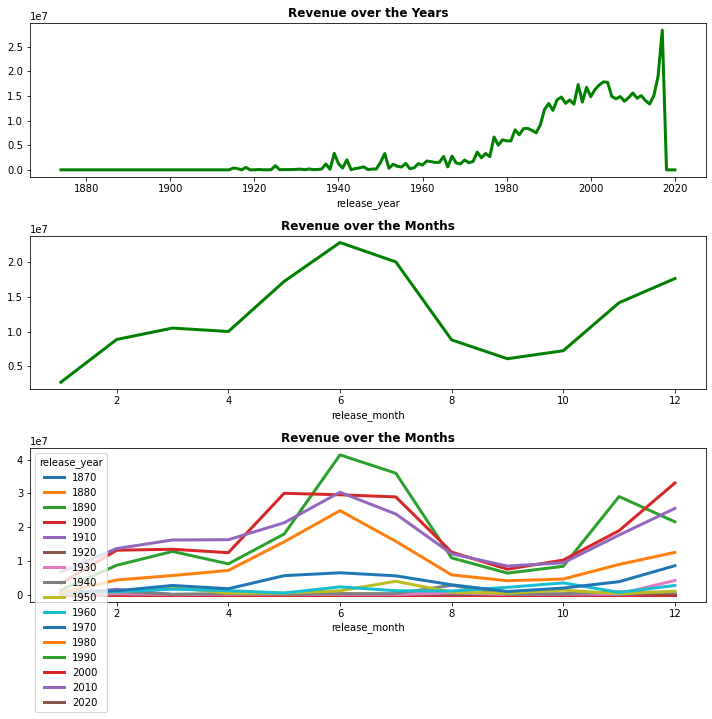

In [246]:
fig, ax = plt.subplots(3, 1, tight_layout=True)
plt.grid()

df.groupby('release_year')['revenue'].mean().plot(ax=ax[0], figsize=(10, 10), linewidth=3, color='green').set_title('Revenue over the Years', fontweight="bold")
df.groupby('release_month')['revenue'].mean().plot(ax=ax[1], figsize=(10, 10), linewidth=3, color='green').set_title('Revenue over the Months', fontweight="bold")


# df['Décennie'] = df['release_year'].apply(lambda x: str(x)[:3] + '0')
dbgroupby = df.groupby(['release_month',df['release_year'].apply(lambda x: str(x)[:3] + '0')])['revenue'].mean()
# dbgroupby.unstack().plot((ax=ax[2], figsize=(10,10))


# df_grouped = df.groupby(['nom', 'année']).sum()
dbgroupby = df.groupby(['release_month',df['release_year'].apply(lambda x: str(x)[:3] + '0')])['revenue'].mean().unstack().plot(ax=ax[2], figsize=(10, 10), linewidth=3).set_title('Revenue over the Months', fontweight="bold")

### One hot encoding

In [247]:
months = ['jan', 'fev', 'mars', 'avril', 'mai', 'juin', 'juil', 'aout', 'sept', 'oct', 'nov', 'dec']

list_test = [months[int(i)-1] for i in df.release_month]
df = df.assign(release_month = list_test)

In [248]:
df = pd.get_dummies(df, columns=['release_month'])

In [249]:
df_genre = pd.Series(df.genres).str.get_dummies(sep=',')
df = pd.concat([df, df_genre], axis = 1) 

In [250]:
df_genre.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [252]:
genre_size = []
for i in df['genres']:
    genre_size.append((len(i.split(','))))
df = df.assign(nb_genre = genre_size)

In [253]:
df.pop('genres')
df.pop('release_date')

0       1995-10-30
1       1995-12-15
2       1995-12-22
3       1995-12-22
4       1995-02-10
           ...    
45532   1991-05-13
45534   2011-11-17
45535   2003-08-01
45536   1917-10-21
45537   2017-06-09
Name: release_date, Length: 45451, dtype: datetime64[ns]

### Budget

Un bugdet et un revenu égal à 0 n'a pas de sens. On peut essayer de remplacer les variables par une moyenne.
Cette étapes aura nécessairement un inlfuence importante sur notre résultat. 
On peut pensé qu'un tel mecanisme peut conduire à influencer positivement l'influence du budget sur le revenu.

In [254]:
df['budget'] = df['budget'].replace(0, df['budget'].mean())
df['revenue'] = df['revenue'].replace(0, df['revenue'].mean())
# df.budget.isnull().sum()

In [255]:
df.head()

,adult,budget,original_language,revenue,runtime,spoken_languages,nb_language,nb_ch,r_fem_ch,r_hom_ch,...,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,nb_genre
0,False,30000000,1,3.735540e+08,81.0,1,1,13,0.230769,0.692308,...,0,0,0,0,0,0,0,0,0,3
1,False,65000000,1,2.627972e+08,104.0,1,2,26,0.230769,0.346154,...,0,0,0,0,0,0,0,0,0,3
2,False,0,1,1.121930e+07,101.0,1,1,7,0.428571,0.571429,...,0,0,0,1,0,0,0,0,0,2
3,False,16000000,1,8.145216e+07,127.0,1,1,10,0.400000,0.600000,...,0,0,0,1,0,0,0,0,0,3
4,False,0,1,7.657891e+07,106.0,1,1,12,0.416667,0.500000,...,0,0,0,0,0,0,0,0,0,1


In [256]:
df.to_csv('./data/diversity.csv', index=False)